In [315]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [316]:
import os
print(os.getcwd()) 

z:\PA_SENTENCING_PROJECT\Home\audrey\PA_sentencing


In [317]:
sns.set_style(style='white') 
palette = ['#7B86BD', '#FFE347', '#F07B46', '#67E6AC', '#15B5FF' ]
race_palette = ['#7B86BD', '#FFE347', '#D3D3D3']
sns.set_palette(palette)

In [318]:
prs_labels = ['0', '1', '2', '3', '4', '5', 'RFEL/REVOC']
prs_labels_vert = ['0', '1', '2', '3', '4', '5', 'RFEL/\nREVOC']
prs8_labels =['0', 'Low', 'Medium', 'High']

In [319]:
recidivism_df = pd.read_csv('Z:/PA_SENTENCING_PROJECT/Project/Data/recidivism_dataset_final.csv')

In [320]:
recidivism_df.head()

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,OGS,PRS8,ADJ_JPMIN,LATEST_JPMIN,CTY_PHL,INCMIN,...,DRUGOFFENSE,DUI,AT_RISK_DT,NEXT_DOF,TIME_TO_RECIDIVATE,RECIDIVISM_3Y,RECIDIVISM_5Y,DOB,OFF_RACE,OFF_SEX
0,1000001,2010-02-18,2009-06-25,0,3.0,1.0,16.0,16.0,0,0.526316,...,0,0,2010-03-06,NaN,NaN,0,0,1990-05-28,White,M
1,1000003,2002-05-08,2001-09-07,0,3.0,2.0,0.0,0.0,0,NaN,...,1,0,2002-05-08,2009-03-04,2492.0,0,0,1961-08-14,White,F
2,1000003,2009-03-04,2009-03-04,3,3.0,3.0,92.0,92.0,0,3.000000,...,0,0,2009-06-04,NaN,NaN,0,0,1961-08-14,White,F
3,1000004,2013-12-10,2013-09-19,0,1.0,2.0,0.0,0.0,0,NaN,...,1,0,2013-12-10,2018-07-09,1672.0,0,1,1993-09-21,Unknown,M
4,1000005,2008-08-11,2006-08-14,0,3.0,1.0,183.0,183.0,0,6.000000,...,0,0,2009-02-10,NaN,NaN,0,0,1987-12-23,Black,F


In [321]:
recidivism_df['OGS'].unique()

array([ 3.,  1.,  5.,  7.,  2.,  6.,  8., 10.,  9.,  4., 11., 12., 14.,
       13.])

In [322]:
orig = recidivism_df.copy()

In [323]:
recidivism_df = recidivism_df[recidivism_df['OGS']!=0]

In [336]:
recidivism_df['PRS'] = np.where(recidivism_df['PRS']=='6', 'RFEL/REVOC', recidivism_df['PRS'])

In [338]:
recidivism_df['PRS'].unique()

array(['0', '3', 'RFEL/REVOC', '2', '4', '5', '1'], dtype=object)

In [339]:
PRS = recidivism_df['PRS'].unique()
PRS.sort()

In [325]:
OGS = recidivism_df['OGS'].unique()
OGS.sort()

In [326]:
PRS8 = recidivism_df['PRS8'].unique()
PRS8.sort()

In [340]:
PRS

array(['0', '1', '2', '3', '4', '5', 'RFEL/REVOC'], dtype=object)

In [341]:
recidivism_df['ADJ_JPMIN'].isna().sum()

210004

In [342]:
recidivism_df[recidivism_df['ID_VARIABLE'] == 1468038][['NEW_DOF', 'NEW_DOS', 'NEXT_DOF']]

,NEW_DOF,NEW_DOS,NEXT_DOF
621415,2005-12-31,2006-09-07,2014-08-18
621416,2014-08-18,2015-03-24,2016-01-28
621417,2016-01-28,2016-05-23,NaN


In [343]:
recidivism_df['OFF_RACE'].unique()

array(['White', 'Unknown', 'Black', 'Other'], dtype=object)

In [344]:
sentence_df = recidivism_df[recidivism_df['ADJ_JPMIN']>0]

### Difference in Means T-Test in Sentencing Length between Black and White Offenders

In [345]:
def get_ttest(df, prs_cat = 'PRS', recidivism = None):

    values = dict()
    if prs_cat == 'PRS':
        prs_vals = PRS

    elif prs_cat == 'PRS8':
        prs_vals = PRS8

    for p in prs_vals:
        for o in OGS:
            if recidivism is None:
                subset = df[(df[prs_cat]==p) & (df['OGS']==o)]
            else:
                subset = df[(df[prs_cat]==p) & (df['OGS']==o) & (df['RECIDIVISM_3Y']==recidivism)]

            black = subset[subset['OFF_RACE']=='Black']
            white = subset[subset['OFF_RACE']=='White']
            results = ttest_ind(black['ADJ_JPMIN'], white['ADJ_JPMIN'])
            values[(p, o)] = {'statistic': results[0], 'p-val': results[1]}
    
    df = pd.DataFrame(values).transpose().reset_index()
    df.rename(columns={'level_0': 'PRS', 'level_1': 'OGS'}, inplace=True)
    df['significance'] = df['p-val'].apply(lambda x: '***' if x < 0.001  else '**' if x < 0.01 else '*' if x < 0.05 else '')
    
    return df

In [346]:
ttest_df = get_ttest(sentence_df, prs_cat = 'PRS')


In [347]:
ttest_df

,PRS,OGS,statistic,p-val,significance
0,0,1.0,15.739452,1.026189e-55,***
1,0,2.0,16.284165,2.031089e-59,***
2,0,3.0,20.674561,1.584452e-94,***
3,0,4.0,9.187428,5.348632e-20,***
4,0,5.0,15.662730,4.039951e-55,***
...,...,...,...,...,...
93,RFEL/REVOC,10.0,-1.371543,1.706238e-01,
94,RFEL/REVOC,11.0,0.052765,9.579931e-01,
95,RFEL/REVOC,12.0,0.082139,9.347022e-01,
96,RFEL/REVOC,13.0,-0.594047,5.711712e-01,


In [348]:
#ttest_df.to_csv('difference_in_JMIN_all.csv', index = False)

#### filter by offenders who recidivate

In [349]:
# values_rec = {}

# for p in PRS:
#     for o in OGS:
#         subset = recidivism_df[(recidivism_df['PRS']==p) & (recidivism_df['OGS']==o) & (recidivism_df['RECIDIVISM_3Y'] == 1)]
#         black = subset[subset['OFF_RACE']=='Black']
#         white = subset[subset['OFF_RACE']=='White']
#         if len(black) > 1 and len(white) > 1:
#             results = ttest_ind(black['ADJ_JPMIN'], white['ADJ_JPMIN'])
#             values_rec[(p, o)] = {'statistic': results[0], 'p-val': results[1]}

In [350]:
ttest_rec_df = get_ttest(sentence_df, prs_cat = 'PRS', recidivism = 1)

C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [351]:
ttest_rec_df

,PRS,OGS,statistic,p-val,significance
0,0,1.0,7.062684,1.757705e-12,***
1,0,2.0,5.360421,8.662398e-08,***
2,0,3.0,9.336804,1.246295e-20,***
3,0,4.0,3.731317,1.998840e-04,***
4,0,5.0,4.755894,2.031412e-06,***
...,...,...,...,...,...
93,RFEL/REVOC,10.0,-0.024081,9.808593e-01,
94,RFEL/REVOC,11.0,NaN,NaN,
95,RFEL/REVOC,12.0,NaN,NaN,
96,RFEL/REVOC,13.0,NaN,NaN,


In [352]:
#ttest_rec_df.to_csv('difference_in_JMIN_rec.csv', index = False)

#### Non-recidivating offenders

In [353]:
ttest_norec_df = get_ttest(sentence_df, prs_cat = 'PRS', recidivism = 0)

In [354]:
ttest_norec_df

,PRS,OGS,statistic,p-val,significance
0,0,1.0,13.779246,3.986057e-43,***
1,0,2.0,15.035357,6.360815e-51,***
2,0,3.0,18.559344,1.513246e-76,***
3,0,4.0,8.416147,4.972760e-17,***
4,0,5.0,15.070855,3.720784e-51,***
...,...,...,...,...,...
93,RFEL/REVOC,10.0,-1.579475,1.147012e-01,
94,RFEL/REVOC,11.0,0.288474,7.734232e-01,
95,RFEL/REVOC,12.0,0.452622,6.518641e-01,
96,RFEL/REVOC,13.0,-0.594047,5.711712e-01,


In [355]:
#ttest_norec_df.to_csv('difference_in_JMIN_norec.csv', index = False)

### Visualizations

All offenders

In [356]:
import matplotlib.colors as colors

In [357]:
#custom_cmap = colors.ListedColormap(['#7b86bd', '#8b92bf', '#c6c6c6', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])


def plot_ttest(df, colors, prs = 'PRS'):
    temp = df[df['OGS']!=0][['PRS', 'OGS', 'statistic', 'p-val']].copy()
    temp.loc[temp['p-val']>=0.05, 'statistic'] = np.nan
    temp = pd.pivot(temp, 'OGS', 'PRS','statistic')
    temp.sort_index(axis=0, ascending=False, inplace=True)
    temp_values = temp.values

    fig, ax = plt.subplots(figsize = (8, 14))
    #custom_cmap = colors.ListedColormap(['#7b86bd', '#8b92bf', '#9a9fc1', '#a9acc3', '#b8b9c5', '#c6c6c6', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])
    #custom_cmap = colors.ListedColormap(['#7b86bd', '#8b92bf', '#c6c6c6', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

    im = ax.imshow(temp_values, cmap=colors)
    #im = ax.imshow(temp_values, cmap="coolwarm")
    ax.set_yticks(np.arange(len(OGS)))
    ax.set_yticklabels(OGS.astype('int')[::-1])
    if prs == 'PRS':
        # ax.set_yticks(np.arange(df.shape[0]))
        # ax.set_yticklabels(PRS[:df.shape[0]])
        ax.set_xticks(np.arange(len(PRS)))
        ax.set_xticklabels(prs_labels_vert)
        ax.set_xlabel('PRS category (7th ed.)', fontsize=15)
    elif prs == 'PRS8':
        ax.set_xticks(np.arange(len(PRS8)))
        ax.set_xticklabels(prs8_labels)
        ax.set_xlabel('Proposed PRS category (8th ed.)', fontsize=15)
    ax.set_ylabel('OGS', fontsize=15)

    #plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    for i in range(temp_values.shape[0]):
        for j in range(temp_values.shape[1]):
            text = ax.text(j, i, temp_values[i, j].round(1), 
            ha='center', va='center', color='w', fontsize = 14)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    #ax.set_title('Difference in Average Sentence for Black vs. White Offenders (days, significant at \u03B1 = 0.95)')
    fig.tight_layout()
    plt.show()

In [358]:
counts = recidivism_df.groupby(by=['PRS', 'OGS'])['ID_VARIABLE'].count().reset_index()

In [359]:
#temp = pd.pivot(counts,  'OGS', 'PRS', 'ID_VARIABLE').values


In [468]:
pd.pivot(counts, 'OGS',  'PRS', 'ID_VARIABLE').sort_values(by='OGS', ascending=False)

PRS,0,1,2,3,4,5,RFEL/REVOC
OGS,,,,,,,
14.0,600,84,93,43,49,52,10
13.0,267,50,32,27,21,38,9
12.0,1564,280,247,145,168,236,107
11.0,3037,562,677,369,365,607,155
10.0,7328,1616,2085,1342,1453,2273,777
9.0,4834,1535,1424,876,781,1144,450
8.0,8921,2025,2191,1349,1396,2313,584
7.0,16301,4237,4993,3192,3036,5553,1751
6.0,16655,4931,6694,4065,4327,8034,1750


In [361]:
counts = sentence_df.groupby(by=['PRS', 'OGS'])['ID_VARIABLE'].count().reset_index()
pd.pivot(counts, 'OGS', 'PRS', 'ID_VARIABLE').reset_index().sort_values('OGS', ascending=False)

PRS,OGS,0,1,2,3,4,5,RFEL/REVOC
13,14.0,600,84,93,43,49,52,10
12,13.0,267,50,32,27,21,38,9
11,12.0,1564,280,247,145,168,236,107
10,11.0,3037,562,677,369,365,607,155
9,10.0,7328,1616,2085,1342,1453,2273,777
8,9.0,4834,1535,1424,876,781,1144,450
7,8.0,8921,2025,2191,1349,1396,2313,584
6,7.0,16301,4237,4993,3192,3036,5553,1751
5,6.0,16655,4931,6694,4065,4327,8034,1750
4,5.0,40534,14688,12001,8305,6845,13931,3862


In [362]:
#pd.pivot(counts, 'OGS', 'PRS', 'ID_VARIABLE').reset_index().sort_values('OGS', ascending=False)[['0', '1', '2', '3', '4', '5' , 'RFEL/REVOC']]

### Visualizations

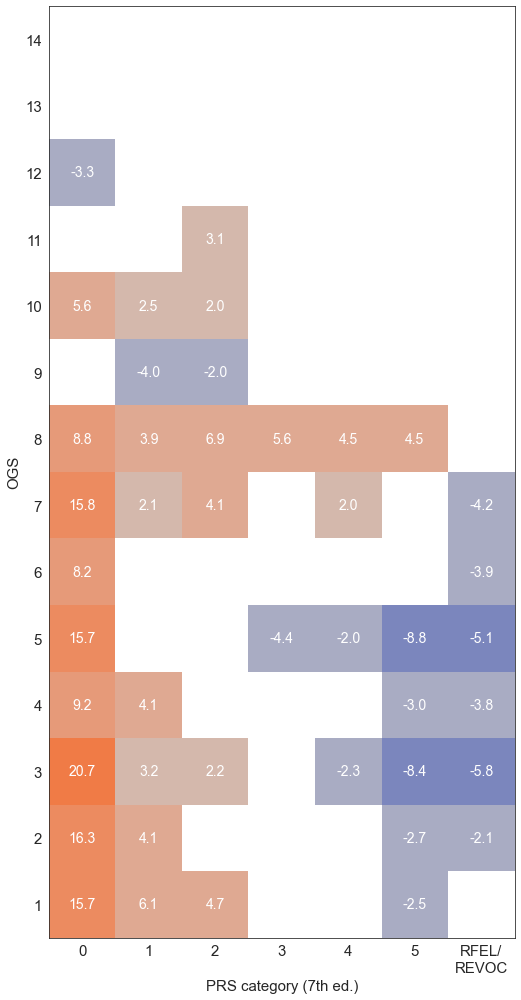

In [472]:
custom_cmap = colors.ListedColormap(['#7b86bd',  '#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest_df, prs='PRS', colors = custom_cmap)

PRS 8th edition

In [214]:
# custom_cmap = colors.ListedColormap(['#7b86bd','#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

# plot_ttest(ttest_prs8_df, prs='PRS8', colors = custom_cmap)

Recidivating offenders

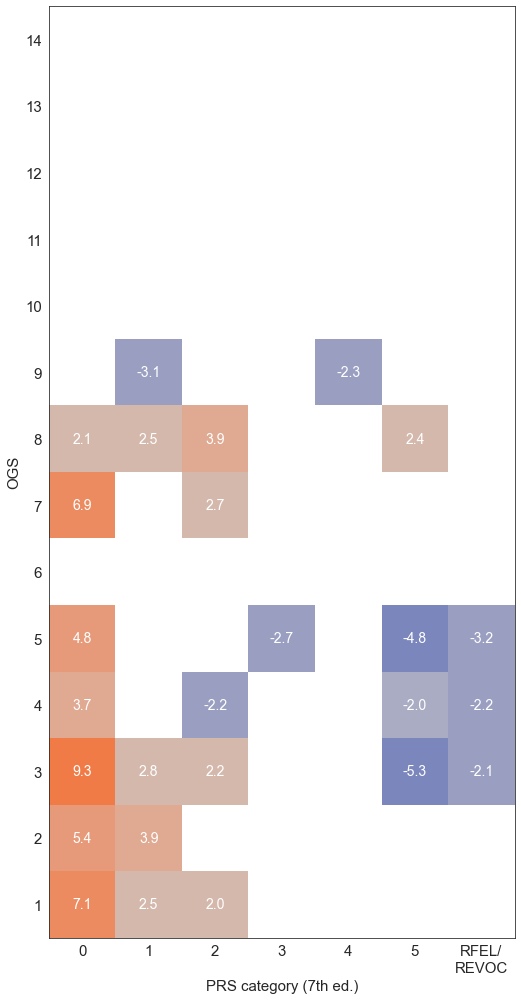

In [365]:
custom_cmap = colors.ListedColormap(['#7b86bd',  '#9a9fc1', '#a9acc3', '#b8b9c5', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest_rec_df, prs='PRS', colors = custom_cmap)

Non-recidivating offenders

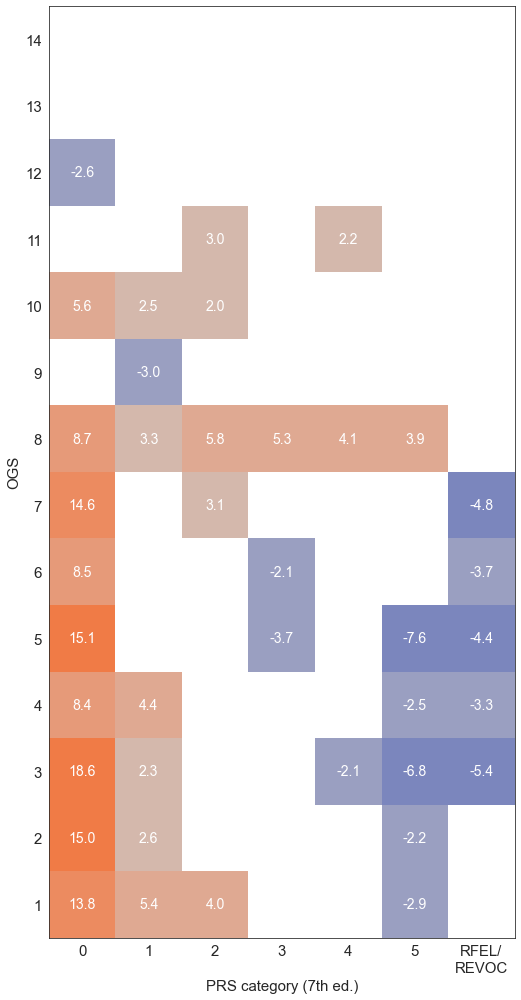

In [366]:
custom_cmap = colors.ListedColormap(['#7b86bd',  '#9a9fc1',   '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest_norec_df, prs='PRS', colors = custom_cmap)

### AD HOC: adding new columns for analysis

In [255]:
#new_cols = pd.read_csv('./supplemental_cols.csv')

In [256]:
#new_cols.rename(columns={'DOS': 'NEW_DOS'}, inplace=True)

In [257]:
#recidivism_df_expanded = pd.merge(recidivism_df, new_cols, on=['ID_VARIABLE', 'NEW_DOS'], how='left')

In [259]:
#recidivism_df_expanded[recidivism_df_expanded['CTY_PHL'].isna()]

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,PRS8,NEW_INC_SANCTION_EXISTS,ADJ_JPMIN,AT_RISK_DT,COUNTY,NEXT_DOF,...,FIREARMS,VIOLENCE,JPS_WALSHACTASSESSMENT,DOB,OFF_RACE,OFF_SEX,index,CTY_PHL,CHARGE_COUNT,INC_REL_NUMERIC
263428,1215876,2013-05-14,2011-01-27,0,4.0,Y,201.0,2013-12-01 00:00:00,Luzerne,NaN,...,False,False,NaN,1980-07-13,White,M,NaN,NaN,NaN,NaN
284011,1232916,2011-01-10,2007-03-03,0,1.0,Y,1007.0,2013-10-13 00:00:00,Clinton,NaN,...,False,True,NaN,1988-04-16,Black,M,NaN,NaN,NaN,NaN
389878,1319554,2016-06-21,2015-08-28,0,1.0,N,0.0,2016-06-21,Monroe,NaN,...,False,False,NaN,1994-01-01,White,M,NaN,NaN,NaN,NaN
520386,1426158,2018-03-06,2015-02-15,4,2.0,Y,-694.0,2016-04-11 00:00:00,Erie,NaN,...,False,False,NaN,1985-06-09,White,M,NaN,NaN,NaN,NaN
821671,1672505,2016-08-26,2016-01-17,2,2.0,Y,243.0,2017-04-26,Montgomery,NaN,...,False,False,NaN,1977-06-28,Black,M,NaN,NaN,NaN,NaN
860828,1704539,2012-08-29,2011-07-20,5,3.0,Y,1826.0,2017-08-29,Lackawanna,NaN,...,False,False,NaN,1974-07-23,Black,M,NaN,NaN,NaN,NaN
1085547,1888889,2016-06-09,2015-03-21,0,1.0,Y,533.0,2017-11-24,Erie,NaN,...,False,False,NaN,1990-10-01,Black,M,NaN,NaN,NaN,NaN


In [166]:
#recidivism_df_expanded.columns

Index(['ID_VARIABLE', 'NEW_DOS', 'NEW_DOF', 'PRS', 'PRS8',
       'NEW_INC_SANCTION_EXISTS', 'ADJ_JPMIN', 'AT_RISK_DT', 'COUNTY',
       'NEXT_DOF', 'TIME_TO_RECIDIVATE', 'RECIDIVISM_3Y', 'RECIDIVISM_5Y',
       'OGS', 'MS_SANCTION', 'SEXCRIME', 'SEXTIER_NUMERIC', 'DUI',
       'DRUGOFFENSE', 'FIREARMS', 'VIOLENCE', 'JPS_WALSHACTASSESSMENT', 'DOB',
       'OFF_RACE', 'OFF_SEX', 'index', 'CTY_PHL', 'CHARGE_COUNT',
       'INC_REL_NUMERIC'],
      dtype='object')

#### First, compare philly with non-philly

In [367]:
# philly
phl = sentence_df[sentence_df['CTY_PHL']==1]

In [368]:
ttest = get_ttest(phl)

C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [369]:
print(len(phl))

49350


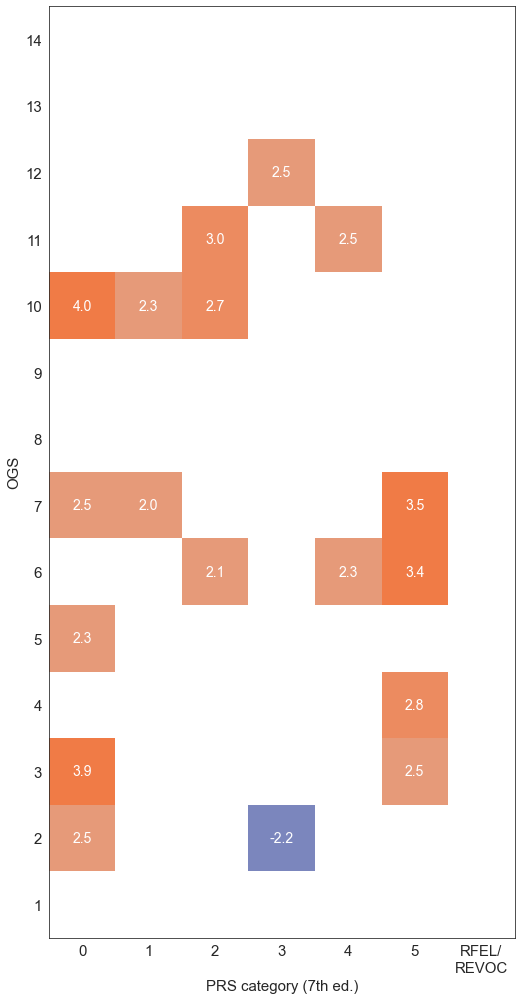

In [370]:
custom_cmap = colors.ListedColormap(['#7b86bd', '#8b92bf', '#9a9fc1', '#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest, prs='PRS', colors = custom_cmap)

In [371]:
# other counties
non_phl = sentence_df[sentence_df['CTY_PHL']==0]

In [372]:
sentence_df['CTY_PHL'].isna().sum()

0

In [373]:
ttest = get_ttest(non_phl)

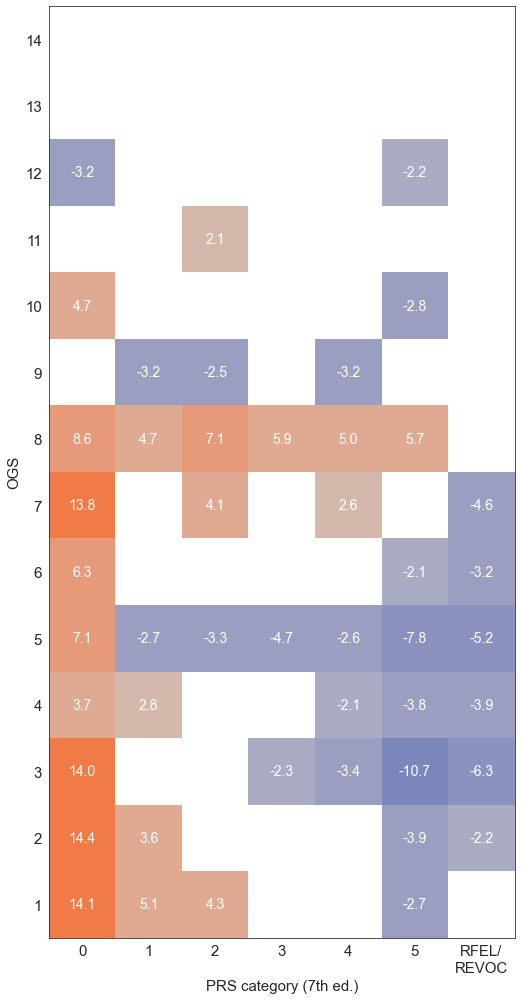

In [374]:
custom_cmap = colors.ListedColormap(['#7b86bd', '#8b92bf', '#9a9fc1', '#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest, prs='PRS', colors = custom_cmap)

##### Look at single count offenses only

In [375]:
singles = sentence_df[sentence_df['CHARGE_COUNT']==1]

In [376]:
sentence_df[sentence_df['CHARGE_COUNT'].isna()]

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,OGS,PRS8,ADJ_JPMIN,LATEST_JPMIN,CTY_PHL,INCMIN,...,DRUGOFFENSE,DUI,AT_RISK_DT,NEXT_DOF,TIME_TO_RECIDIVATE,RECIDIVISM_3Y,RECIDIVISM_5Y,DOB,OFF_RACE,OFF_SEX


In [377]:
ttest = get_ttest(singles)

C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [378]:
print(len(singles))

383339


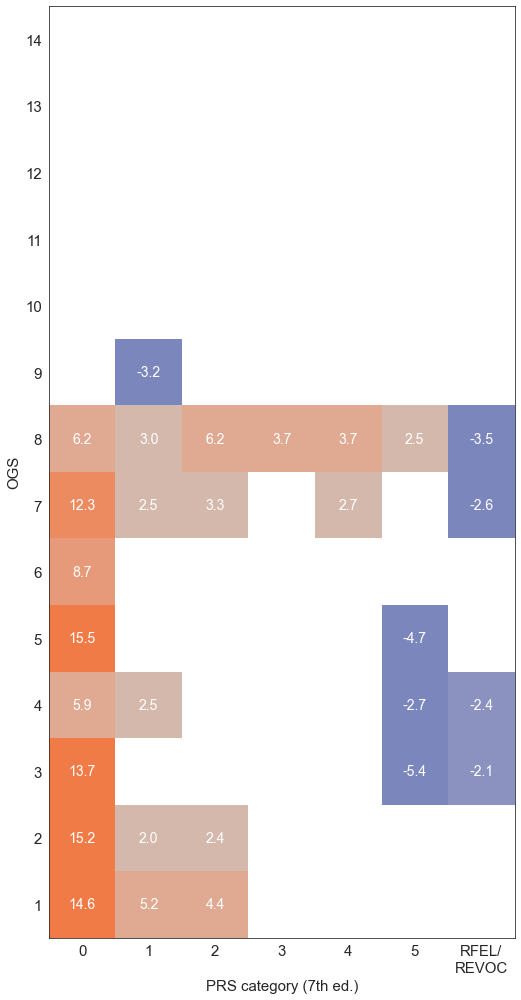

In [379]:
custom_cmap = colors.ListedColormap(['#7b86bd', '#8b92bf', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest, prs='PRS', colors = custom_cmap)

In [380]:
# multiples
multiples = sentence_df[sentence_df['CHARGE_COUNT']>1]

In [381]:
print(len(multiples))

217118


In [382]:
ttest = get_ttest(multiples)

C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


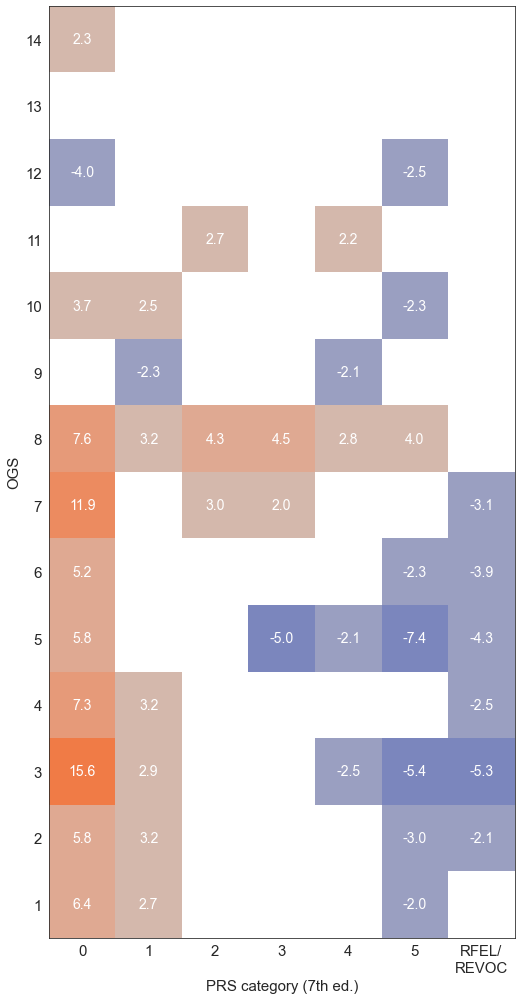

In [383]:
custom_cmap = colors.ListedColormap(['#7b86bd',  '#9a9fc1', '#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest, prs='PRS', colors = custom_cmap)

#### Concurrent vs. consecutive

In [384]:
concurrent = sentence_df[sentence_df['INC_REL_NUMERIC']==1]

In [385]:
ttest = get_ttest(concurrent)

C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


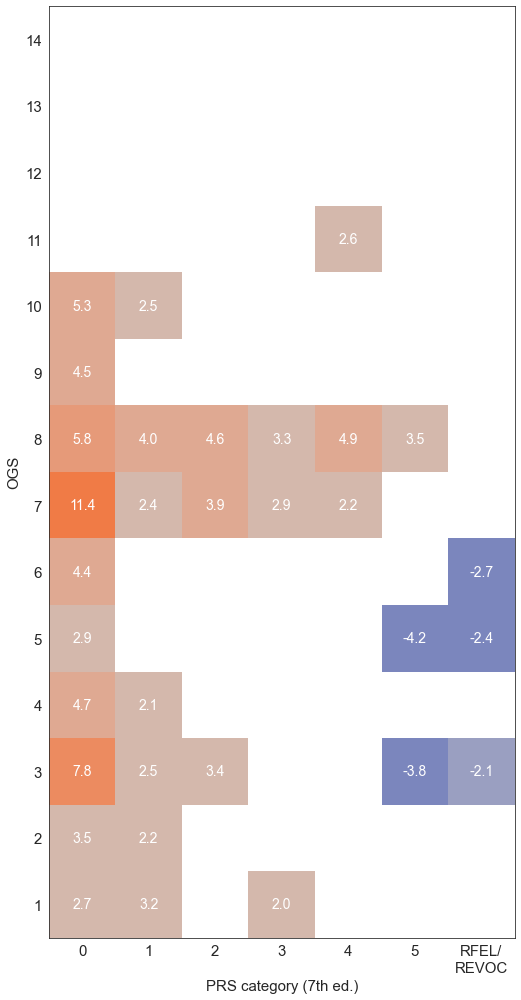

In [386]:
custom_cmap = colors.ListedColormap(['#7b86bd',  '#9a9fc1', '#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest, prs='PRS', colors = custom_cmap)

In [387]:
consecutive = sentence_df[sentence_df['INC_REL_NUMERIC'] == 2]

In [388]:
ttest = get_ttest(consecutive)

C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\audre\anaconda3\envs\pa_sentencing\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


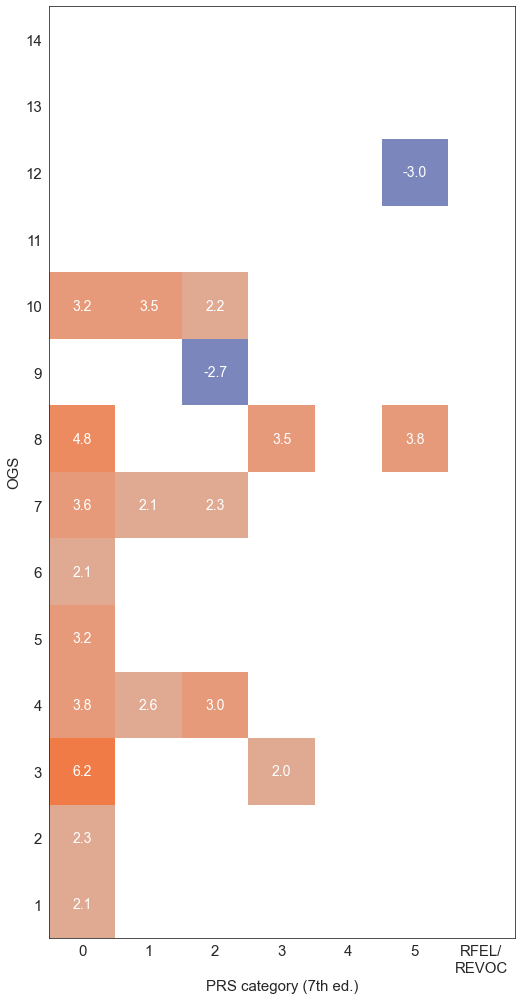

In [389]:
custom_cmap = colors.ListedColormap(['#7b86bd',  '#9a9fc1', '#a9acc3', '#d4b8ac', '#dfa992', '#e69a79', '#ec8b60', '#f07b46'])

plot_ttest(ttest, prs='PRS', colors = custom_cmap)

### Sentencing length by PRS

In [493]:
def plot_category(df, category=None, legend_loc = 'upper left', 
                x = 'PRS', y = 'RECIDIVISM_3Y', xaxis = None, ylabel = 'Recidivism rate (%)',
                palette = palette, 
                legend_title = None, hue_order = None, figsize = (14, 8)):
                
    fig, ax = plt.subplots(figsize=figsize) 
    sns.set_palette(palette)
    if category is not None:
        p = sns.barplot(x=x, y=y, hue=category, data=df,  ax=ax, hue_order = hue_order)
    else:
        p = sns.barplot(x=x, y=y, data=df,  ax=ax)

    sns.despine(top=True, right=True, left=True, bottom=True)

    if x == 'PRS': 
        x_axis = 'PRS category (7th ed.)'
        p.set(xticklabels = prs_labels)
    elif x == 'PRS8':
        x_axis = 'Proposed PRS category (8th ed.)'
        p.set(xticklabels = prs8_labels) 
    elif x == 'OGS':
        x_axis = 'OGS'
        p.set(xticklabels = [int(i) for i in OGS])
    else:
        x_axis = xaxis
        
    p.set_xlabel(x_axis, fontsize=15)
    # if y == 'RECIDIVISM_3Y'
    # p.set_ylabel('Recidivism rate (%)', fontsize=15)
    p.set_ylabel(ylabel, fontsize=15)
    p.set(yticklabels=[])
    ax.legend(loc= legend_loc, title = legend_title, prop={"size": 13}) 
    plt.xticks(fontsize=15)
    if category is not None:
        n_cats = len(df[category].unique())
        for i in range(n_cats):
            ax.bar_label(ax.containers[i], label_type='edge', fmt='%1.1f', fontsize=13)
    else:
        ax.bar_label(ax.containers[0], label_type='edge', fmt='%1.1f', fontsize=13)

    plt.show()

All offenders

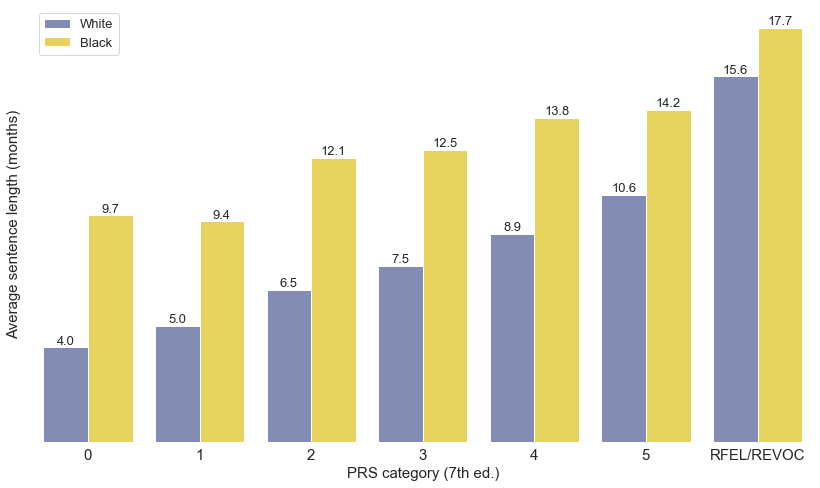

In [444]:
# Mean 
temp = (sentence_df.groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].mean()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category( category='OFF_RACE', df = temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = 'Average sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

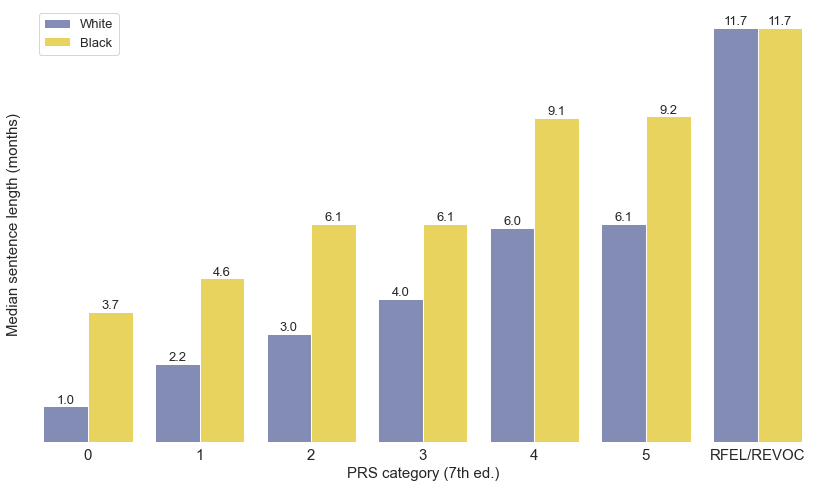

In [445]:
# Median 

temp = (sentence_df.groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].median()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]
plot_category(category = 'OFF_RACE', df = temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = 'Median sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

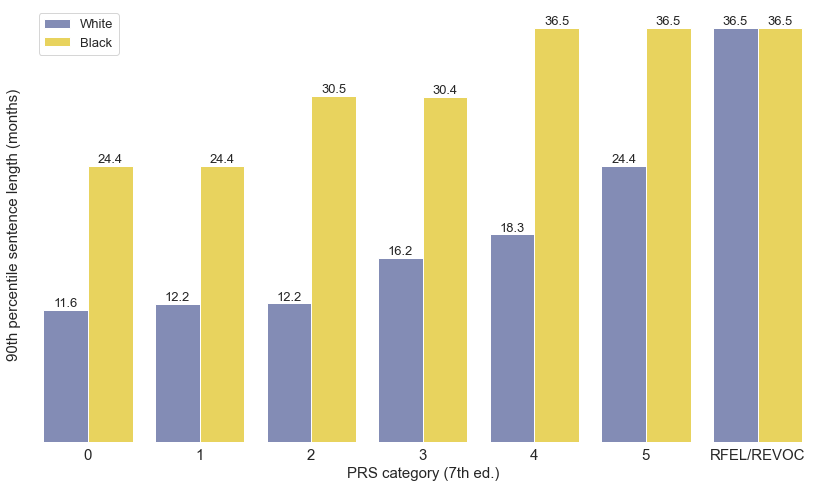

In [446]:
# 90th percentile  

temp = (sentence_df.groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].quantile(0.9)/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]
plot_category(category = 'OFF_RACE', df = temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = '90th percentile sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

In [447]:
def get_summary_stats(df, prs = 'PRS', method = 'mean', recidivism = None):
    if recidivism is not None:
        df = df[df['RECIDIVISM_3Y'] == recidivism] 
    
    if method == 'mean':
        temp = (df.groupby(by=['OFF_RACE', prs])['ADJ_JPMIN'].mean()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
    elif method == 'median':
        temp = (df.groupby(by=['OFF_RACE', prs])['ADJ_JPMIN'].median()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
    elif method == 'pct':
        temp = (df.groupby(by=['OFF_RACE', prs])['ADJ_JPMIN'].quantile(0.9)/30).reset_index().rename(columns={'index': 'OFF_RACE'})
    temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

    return temp

#### Plotting on one plot

In [448]:
# def plot_category_multi(category, df, recidivism = None, method='mean', legend_loc = 'upper left', 
#                 x = 'PRS', y = 'ADJ_JPMIN', 
#                 palette = palette, 
#                 legend_title = None, hue_order = None, figsize = (14, 8)):
                
#     df1 = get_summary_stats(df, prs='PRS', method=method, recidivism = recidivism)
#     df2 = get_summary_stats(df, prs='PRS8', method=method, recidivism = recidivism)

#     if method == 'mean':
#         ylabel = 'Average sentence length (months)'
#     elif method == 'median':
#         ylabel = 'Median sentence length (months)'
#     elif method == 'pct':
#         ylabel = '90th percentile sentence length (months)'

#     fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios':[1.75,1]}) 
#     sns.set_palette(palette)
#     p1 = sns.barplot(x='PRS', y=y, hue=category, data=df1,  ax=ax[0], hue_order = hue_order)
#     p2 =sns.barplot(x='PRS8', y=y, hue=category, data=df2,  ax=ax[1], hue_order = hue_order)
#     sns.despine(top=True, right=True, left=True, bottom=True)

#     p1.set(xticklabels = prs_labels)
#     p2.set(xticklabels = prs8_labels) 
        
#     p1.set_title('7th Edition', fontsize=15)
#     p2.set_title('8th Edition', fontsize=15)
#     plt.suptitle('PRS category', x=0.5, y=0.05, fontsize=15)
#     p1.set_ylabel(ylabel, fontsize=15)
#     p1.set(yticklabels=[])
#     p2.set_ylabel(None)
#     p2.set(yticklabels=[])
#     p1.set_xlabel(None)
#     p2.set_xlabel(None)
#     ax[0].legend(loc= legend_loc, title = legend_title, prop={"size": 13}) 
#     ax[1].get_legend().remove()
#     #p1.xticks(fontsize=15)
#     #p2.xticks(fontsize=15) 
#     p1.tick_params(axis='both', which='major', labelsize=13)
#     p2.tick_params(axis='both', which='major', labelsize=13)

#     n_cats = len(df1[category].unique())
#     for a in range(2):
#         for i in range(n_cats):
#             ax[a].bar_label(ax[a].containers[i], label_type='edge', fmt='%1.1f', fontsize=13)
#     plt.subplots_adjust(wspace=0.1)
#     plt.show()

In [449]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='mean', recidivism = None, hue_order=['White', 'Black'])

In [450]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='median', recidivism = None, hue_order=['White', 'Black'])

In [451]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='pct', recidivism = None, hue_order=['White', 'Black'])

Non - recidivating

In [452]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='mean', recidivism = 0, hue_order=['White', 'Black'])

In [453]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='median', recidivism = 0, hue_order=['White', 'Black'])

In [454]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='pct', recidivism = 0, hue_order=['White', 'Black'])

Recidivating

In [455]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='mean', recidivism = 1, hue_order=['White', 'Black'])

In [456]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='median', recidivism = 1, hue_order=['White', 'Black'])

In [457]:
#plot_category_multi('OFF_RACE', df=recidivism_df, method='pct', recidivism = 1, hue_order=['White', 'Black'])

TTest

In [458]:
def category_ttest(category = 'PRS', recidivism = None):
    values = {} 
    if category == 'PRS':
        cats = PRS 
    elif category == 'PRS8':
        cats = PRS8
    elif category == 'OGS':
        cats = OGS

    for c in cats:
        if recidivism is None:
            subset = sentence_df[(sentence_df[category]==c)]
        else:
            subset = sentence_df[(sentence_df[category]==c) & (sentence_df['RECIDIVISM_3Y'] == 1)]

        black = subset[subset['OFF_RACE']=='Black']
        white = subset[subset['OFF_RACE']=='White']
        if len(black) > 1 and len(white) > 1:
            results = ttest_ind(black['ADJ_JPMIN'], white['ADJ_JPMIN'])
            values[c] = {'statistic': results[0], 'p-val': results[1]}
    
    df = pd.DataFrame(values).transpose().reset_index().rename(columns={'index': category})

    df['significance'] = df['p-val'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else '')
    
    return df

In [459]:
ttest_prs_df = category_ttest(category = 'PRS')

In [404]:
ttest_prs_df

,PRS,statistic,p-val,significance
0,0,103.053054,0.000000e+00,***
1,1,47.912735,0.000000e+00,***
2,2,52.696406,0.000000e+00,***
3,3,36.505607,2.546309e-287,***
4,4,33.286675,1.673237e-239,***
5,5,34.130989,2.070088e-253,***
6,RFEL/REVOC,8.285213,1.244330e-16,***


Filter to those who recidivate

In [460]:
#Mean

temp = (sentence_df[sentence_df['RECIDIVISM_3Y']==1].groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].mean()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

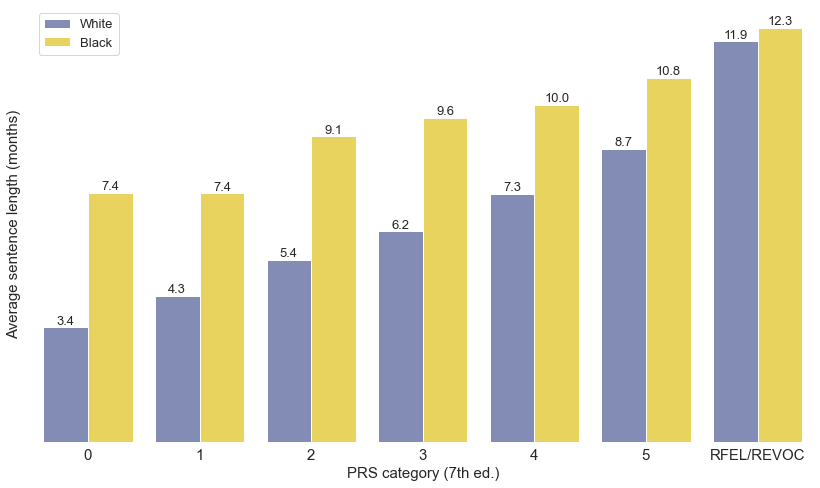

In [461]:
plot_category(category='OFF_RACE', df=temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = 'Average sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

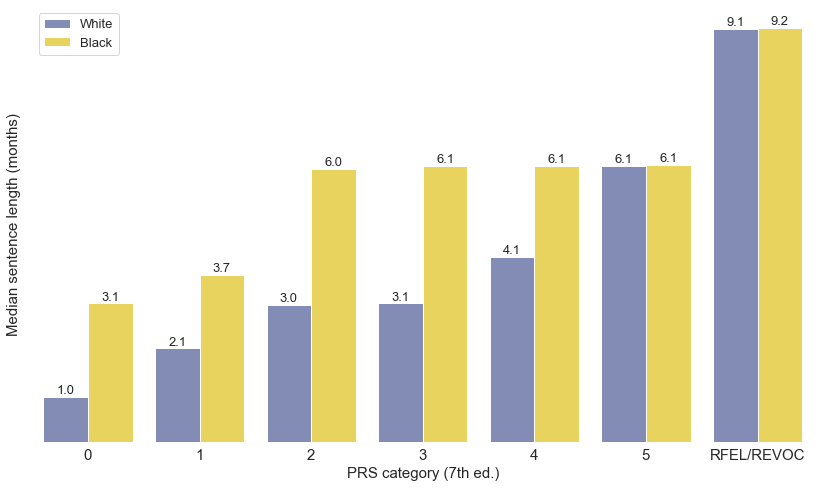

In [462]:
#Median

temp = (sentence_df[sentence_df['RECIDIVISM_3Y']==1].groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].median()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = 'Median sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

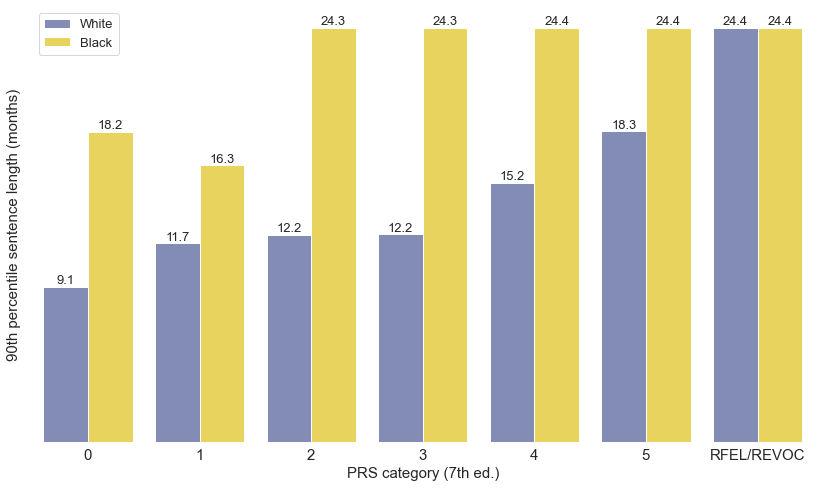

In [463]:
# 90th pct

temp = (sentence_df[sentence_df['RECIDIVISM_3Y']==1].groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].quantile(0.9)/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = '90th percentile sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

In [464]:
ttest_prs_df = category_ttest(category = 'PRS', recidivism = 1)
ttest_prs_df

,PRS,statistic,p-val,significance
0,0,39.605597,0.000000e+00,***
1,1,19.095505,2.750910e-80,***
2,2,21.138433,1.457861e-97,***
3,3,15.122473,4.540049e-51,***
4,4,11.135883,1.336173e-28,***
5,5,12.255420,2.169968e-34,***
6,RFEL/REVOC,1.029776,3.031716e-01,


Filter to those who do not recidivate

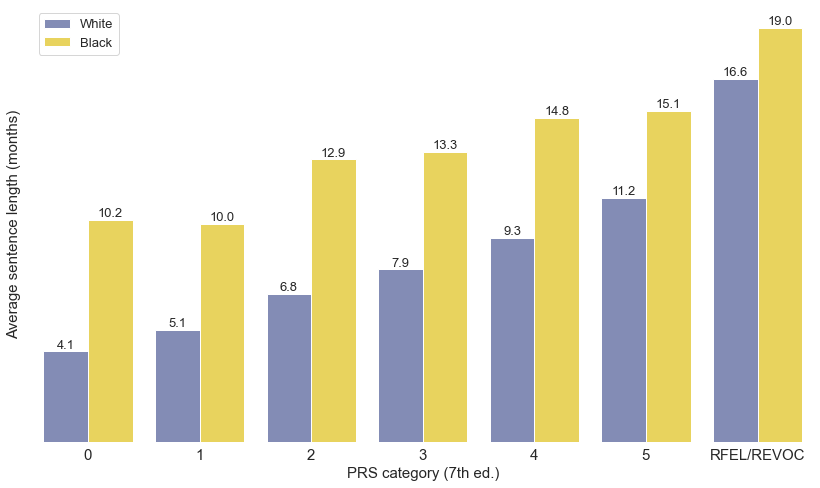

In [465]:
temp = (sentence_df[sentence_df['RECIDIVISM_3Y']==0].groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].mean()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = 'Average sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

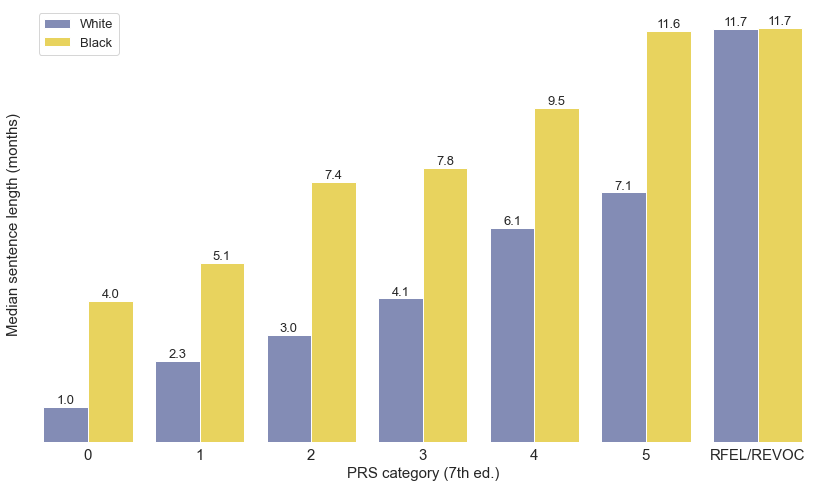

In [466]:
# Median

temp = (sentence_df[sentence_df['RECIDIVISM_3Y']==0].groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].median()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = 'Median sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

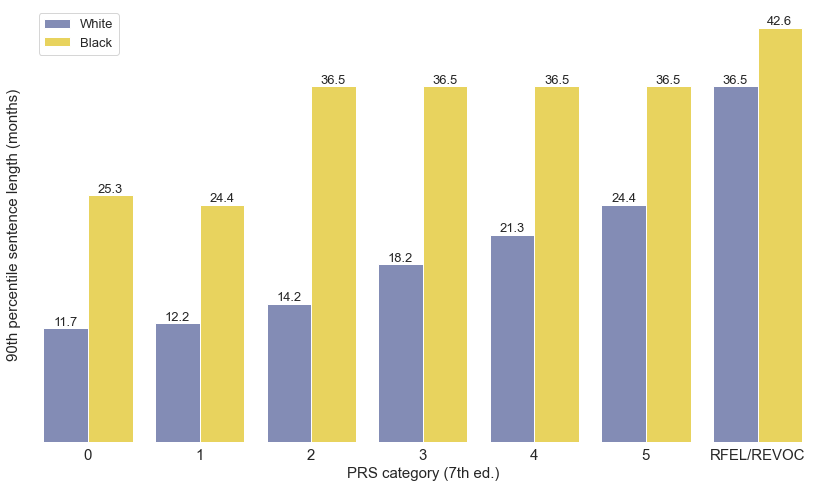

In [467]:
# 90th pct

temp = (sentence_df[sentence_df['RECIDIVISM_3Y']==0].groupby(by=['OFF_RACE', 'PRS'])['ADJ_JPMIN'].quantile(0.9)/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'PRS', 
y = 'ADJ_JPMIN', ylabel = '90th percentile sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'])

In [433]:
ttest_prs_norec_df = category_ttest(category = 'PRS', recidivism = 0)

In [434]:
ttest_prs_norec_df['significance'] = ttest_prs_norec_df['p-val'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else '')

In [435]:
ttest_norec_prs_df = category_ttest(category = 'PRS', recidivism = 0)
ttest_norec_prs_df

,PRS,statistic,p-val,significance
0,0,39.605597,0.000000e+00,***
1,1,19.095505,2.750910e-80,***
2,2,21.138433,1.457861e-97,***
3,3,15.122473,4.540049e-51,***
4,4,11.135883,1.336173e-28,***
5,5,12.255420,2.169968e-34,***
6,RFEL/REVOC,1.029776,3.031716e-01,


### Sentencing length by OGS

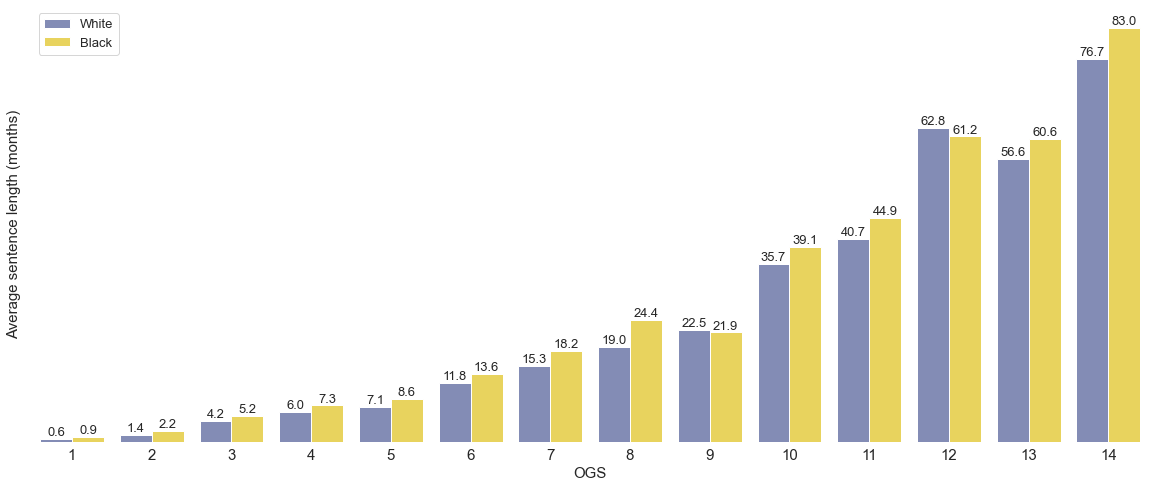

In [436]:
# average 

temp = (sentence_df.groupby(by=['OFF_RACE', 'OGS'])['ADJ_JPMIN'].mean()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'OGS', 
y = 'ADJ_JPMIN', ylabel = 'Average sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'], figsize = (20, 8))

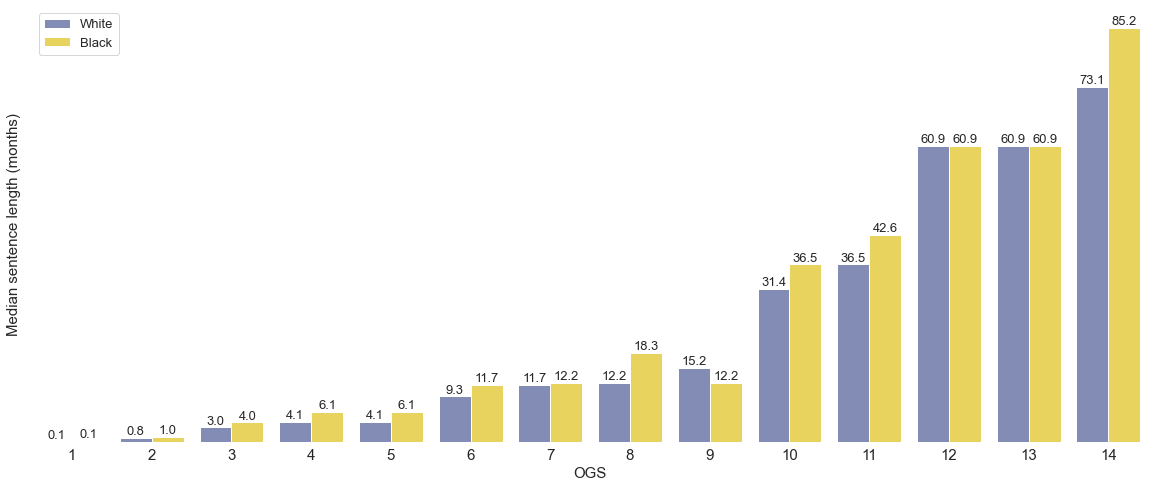

In [437]:
# Median

temp = (sentence_df.groupby(by=['OFF_RACE', 'OGS'])['ADJ_JPMIN'].median()/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'OGS', 
y = 'ADJ_JPMIN', ylabel = 'Median sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'], figsize = (20, 8))

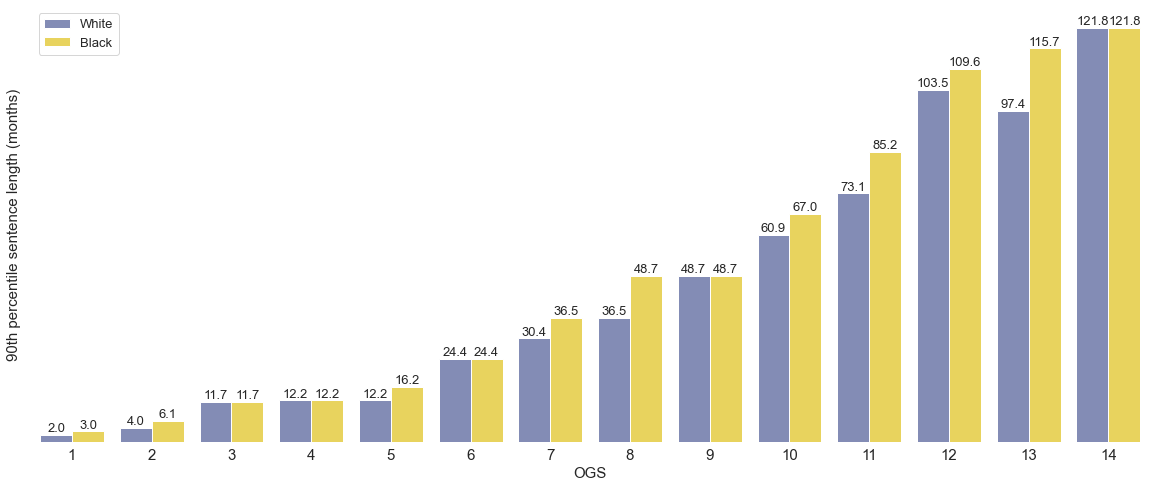

In [438]:
# 90th pct

temp = (sentence_df.groupby(by=['OFF_RACE', 'OGS'])['ADJ_JPMIN'].quantile(0.9)/30).reset_index().rename(columns={'index': 'OFF_RACE'})
temp = temp[temp['OFF_RACE'].isin(['Black', 'White'])]

plot_category(category='OFF_RACE', df=temp, x = 'OGS', 
y = 'ADJ_JPMIN', ylabel = '90th percentile sentence length (months)', 
palette = race_palette, hue_order = ['White', 'Black'], figsize = (20, 8))

In [439]:
ttest_ogs_df = category_ttest(category = 'OGS')
ttest_ogs_df

,OGS,statistic,p-val,significance
0,1.0,33.121667,1.949301e-239,***
1,2.0,33.287797,3.962199e-241,***
2,3.0,36.887956,2.212465e-296,***
3,4.0,12.732800,5.797225e-37,***
4,5.0,27.954853,2.858501e-171,***
5,6.0,18.889736,2.989893e-79,***
6,7.0,22.158187,4.656119e-108,***
7,8.0,21.125316,8.558757e-98,***
8,9.0,-1.487819,1.368292e-01,
9,10.0,8.587653,9.722201e-18,***


Incarceration vs. no incarceration 

In [440]:
inc_by_PRS = recidivism_df.groupby(by=['PRS', 'OFF_RACE']).apply(lambda x: (x['ADJ_JPMIN']>0).sum() / len(x)) * 100

In [441]:
inc_by_PRS = inc_by_PRS.reset_index().rename(columns = {'index': 'PRS', 0: 'INC_PCT'})

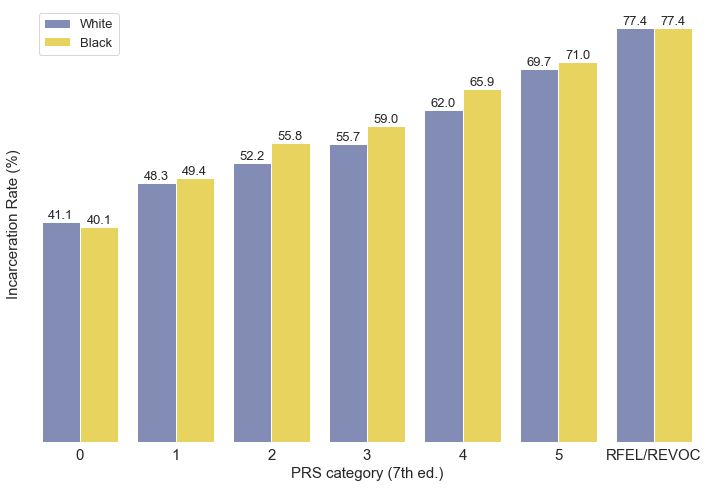

In [442]:
plot_category(category = 'OFF_RACE', df=inc_by_PRS[inc_by_PRS['OFF_RACE'].isin(['Black', 'White'])], y='INC_PCT', ylabel='Incarceration Rate (%)', hue_order=['White', 'Black'])

In [473]:
orig.shape

(1216238, 29)

In [475]:
recidivism_df.shape

(1216238, 29)

In [476]:
def age_grp(x):
    if x < 18:
        return '<18'
    elif x < 21:
        return "18-20"
    elif x < 25:
        return "21-24"
    else:
        return "25+"

In [478]:
recidivism_df['DOB'] = pd.to_datetime(recidivism_df['DOB'])

In [479]:
recidivism_df['NEW_DOF'] = pd.to_datetime(recidivism_df['NEW_DOF'])

In [484]:
recidivism_df["AGE"] = (recidivism_df["NEW_DOF"] - recidivism_df["DOB"]).dt.days / 365.25

In [485]:
recidivism_df["AGE_GRP"] = recidivism_df['AGE'].apply(lambda x: age_grp(x))

In [486]:
recidivism_df[["DOB", "AGE", "AGE_GRP", 'NEW_DOF']]

,DOB,AGE,AGE_GRP,NEW_DOF
0,1990-05-28,19.077344,18-20,2009-06-25
1,1961-08-14,40.065708,25+,2001-09-07
2,1961-08-14,47.553730,25+,2009-03-04
3,1993-09-21,19.994524,18-20,2013-09-19
4,1987-12-23,18.642026,18-20,2006-08-14
...,...,...,...,...
1216233,1958-03-28,56.106776,25+,2014-05-06
1216234,1966-03-14,35.137577,25+,2001-05-03
1216235,1978-11-01,36.407940,25+,2015-03-30
1216236,1975-12-01,33.456537,25+,2009-05-16


In [488]:
distros = recidivism_df[recidivism_df['OFF_RACE'].isin(['Black', 'White'])].groupby(by=['OFF_RACE', 'AGE_GRP'])['ID_VARIABLE'].count() / recidivism_df.groupby(by='OFF_RACE')['ID_VARIABLE'].count()

In [489]:
distros = distros * 100

In [490]:
distros = pd.DataFrame(distros).reset_index()

In [508]:
mappings = pd.DataFrame(['<18', '18-20', '21-24', '25+'], columns=['AGE_GRP']).reset_index().set_index('AGE_GRP')

In [509]:
mappings

,index
AGE_GRP,
<18,0
18-20,1
21-24,2
25+,3


In [510]:
distros['order'] = distros['AGE_GRP'].map(mappings['index'])

In [512]:
distros.sort_values(by='order', inplace=True)

In [515]:
distros

,OFF_RACE,AGE_GRP,ID_VARIABLE,order
3,Black,<18,0.833287,0
7,White,<18,0.251210,0
0,Black,18-20,17.891643,1
4,White,18-20,13.143576,1
1,Black,21-24,18.969457,2
5,White,21-24,17.767412,2
2,Black,25+,62.305613,3
6,White,25+,68.837802,3


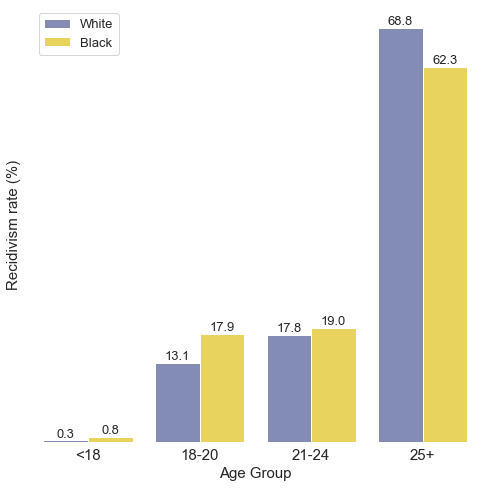

In [514]:
plot_category(distros, category='OFF_RACE', x='AGE_GRP', y='ID_VARIABLE', xaxis = "Age Group", hue_order = ['White', 'Black'], figsize=(8, 8))